In [2]:
# !pip install regex, demoji, plotly, wordcloud

In [6]:
import pandas as pd
import re

import regex
import demoji

import numpy as np
from collections import Counter

import plotly.express as px
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

import streamlit as st

### Paso 1: Definir funciones necesarias

In [7]:
# Funciones auxiliares
def IniciaConFechaYHora(s):
    patron = r'^\d{1,2}/\d{1,2}/\d{2,4}\s\d{1,2}:\d{2}.*\s-\s'
    return re.match(patron, s) is not None

def ObtenerPartes(linea):
    partes = linea.split(' - ', 1)
    fecha_hora = partes[0].strip()  # Ej: '23/07/25 12:35 a. m.'
    resto = partes[1] if len(partes) > 1 else ''
    # Limpiar el AM/PM raro (reemplazar espacio unicode por espacio normal)
    fecha_hora = fecha_hora.replace('\u202f', ' ').replace(' ', ' ')  # Algunos dispositivos usan variantes
    if ': ' in resto:
        Miembro, Mensaje = resto.split(': ', 1)
    else:
        Miembro, Mensaje = None, resto
    return fecha_hora, Miembro, Mensaje

### Paso 2: Obtener el dataframe usando el archivo txt y las funciones definidas

In [9]:
RutaChat = 'Data/Chat de WhatsApp con Paola Rousse ❤️.txt'
with open(RutaChat, encoding="utf-8") as fp:
    lineas = fp.readlines()

# Procesar líneas
DatosLista = []
FechaHora, Miembro, Mensaje = None, None, ""
for linea in lineas:
    linea = linea.strip()
    if IniciaConFechaYHora(linea):
        if Mensaje and Miembro:
            DatosLista.append([FechaHora, Miembro, Mensaje])
        FechaHora, Miembro, Mensaje = ObtenerPartes(linea)
    else:
        Mensaje += " " + linea
if Mensaje and Miembro:
    DatosLista.append([FechaHora, Miembro, Mensaje])

# Crear DataFrame
df = pd.DataFrame(DatosLista, columns=['FechaHora', 'Miembro', 'Mensaje'])

# Convertir columna FechaHora a datetime (flexible, sin formato fijo)
df['FechaHora'] = pd.to_datetime(df['FechaHora'], dayfirst=True, errors='coerce')

# Eliminar errores de parseo
df = df.dropna(subset=['FechaHora', 'Miembro', 'Mensaje']).reset_index(drop=True)

# Separar Fecha y Hora si quieres
df['Fecha'] = df['FechaHora'].dt.date
df['Hora'] = df['FechaHora'].dt.time
df

C:\Users\ikkiel\AppData\Local\Temp\ipykernel_7988\817040096.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['FechaHora'] = pd.to_datetime(df['FechaHora'], dayfirst=True, errors='coerce')


,FechaHora,Miembro,Mensaje,Fecha,Hora
0,2025-06-04 21:14:00,Paola Rousse ❤️,Ya volvi,2025-06-04,21:14:00
1,2025-06-04 21:14:00,Paola Rousse ❤️,Ya shegue,2025-06-04,21:14:00
2,2025-06-04 21:14:00,Paola Rousse ❤️,JAJA POBRECITO,2025-06-04,21:14:00
3,2025-06-04 21:14:00,Paola Rousse ❤️,Cual t comprastee,2025-06-04,21:14:00
4,2025-06-04 21:14:00,Gabriel Paiva,JAJAJAJA hooola,2025-06-04,21:14:00
...,...,...,...,...,...
50621,2025-07-23 09:03:00,Gabriel Paiva,Pipipi,2025-07-23,09:03:00
50622,2025-07-23 09:04:00,Gabriel Paiva,Como tash,2025-07-23,09:04:00
50623,2025-07-23 09:04:00,Gabriel Paiva,Ya ta bien mi vida??,2025-07-23,09:04:00
50624,2025-07-23 09:04:00,Gabriel Paiva,Buenos días,2025-07-23,09:04:00


### Paso 3: Estadísticas de mensajes, multimedia, emojis y links

#### Total de mensajes, multimedia, emojis y links enviados

In [16]:
def ObtenerEmojis(Mensaje):
    emoji_lista = []
    data = regex.findall(r'\X', Mensaje)  # Obtener lista de caracteres de cada mensaje
    for caracter in data:
        if demoji.replace(caracter) != caracter:
            emoji_lista.append(caracter)
    return emoji_lista

# Obtener la cantidad total de mensajes
total_mensajes = df.shape[0]

# Obtener la cantidad de archivos multimedia enviados
multimedia_mensajes = df[df['Mensaje'] == '<Multimedia omitido>'].shape[0]

# Obtener la cantidad de emojis enviados
df['Emojis'] = df['Mensaje'].apply(ObtenerEmojis) # Se agrega columna 'Emojis'
emojis = sum(df['Emojis'].str.len())

# Obtener la cantidad de links enviados
url_patron = r'(https?://\S+)'
df['URLs'] = df.Mensaje.apply(lambda x: len(re.findall(url_patron, x))) # Se agrega columna 'URLs'
links = sum(df['URLs'])

# Obtener la cantidad de encuestas
encuestas = df[df['Mensaje'] == 'POLL:'].shape[0]

# Todos los datos pasarlo a diccionario
estadistica_dict = {'Tipo': ['Mensajes', 'Multimedia', 'Emojis', 'Links', 'Encuestas'],
        'Cantidad': [total_mensajes, multimedia_mensajes, emojis, links, encuestas]
        }

#Convertir diccionario a dataframe
estadistica_df = pd.DataFrame(estadistica_dict, columns = ['Tipo', 'Cantidad'])

# Establecer la columna Tipo como índice
estadistica_df = estadistica_df.set_index('Tipo')
estadistica_df

,Cantidad
Tipo,
Mensajes,50626
Multimedia,7482
Emojis,2333
Links,26
Encuestas,0


#### Emojis más usados

In [17]:
# Obtener emojis más usados y las cantidades en el chat del grupo del dataframe
emojis_lista = list([a for b in df.Emojis for a in b])
emoji_diccionario = dict(Counter(emojis_lista))
emoji_diccionario = sorted(emoji_diccionario.items(), key=lambda x: x[1], reverse=True)

# Convertir el diccionario a dataframe
emoji_df = pd.DataFrame(emoji_diccionario, columns=['Emoji', 'Cantidad'])

# Establecer la columna Emoji como índice
emoji_df = emoji_df.set_index('Emoji').head(10)

print('Número emojis únicos usados: ', len(emoji_df), '\n')
emoji_df

Número emojis únicos usados:  10 



,Cantidad
Emoji,
😂,316
😭,292
🥰,213
🫶🏻,198
🥺,169
😜,138
💘,123
🙄,100
❤️,91


In [19]:
# Plotear el pie de los emojis más usados
fig = px.pie(emoji_df, values='Cantidad', names=emoji_df.index, hole=.3, template='plotly_dark', color_discrete_sequence=px.colors.qualitative.Pastel2)
fig.update_traces(textposition='inside', textinfo='percent+label', textfont_size=20)
fig.update_layout(title={'text': '🤗 Emojis que más usamos', 'y':0.96, 'x':0.5, 'xanchor': 'center'}, font=dict(size=17))
fig.show()

### Paso 4: Estadísticas de los miembros del grupo

#### Miembros más activos

In [20]:
# Determinar los miembros más activos del grupo
df_MiembrosActivos = df.groupby('Miembro')['Mensaje'].count().sort_values(ascending=False).to_frame()
df_MiembrosActivos.reset_index(inplace=True)
df_MiembrosActivos.index = np.arange(1, len(df_MiembrosActivos)+1)
df_MiembrosActivos['% Mensaje'] = (df_MiembrosActivos['Mensaje'] / df_MiembrosActivos['Mensaje'].sum()) * 100
df_MiembrosActivos

,Miembro,Mensaje,% Mensaje
1,Paola Rousse ❤️,25382,50.136294
2,Gabriel Paiva,25244,49.863706


#### Estadísticas por miembro

In [21]:
# Separar mensajes (sin multimedia) y multimedia (stickers, fotos, videos)
multimedia_df = df[df['Mensaje'] == '<Multimedia omitido>']
mensajes_df = df.drop(multimedia_df.index)

# Contar la cantidad de palabras y letras por mensaje
mensajes_df['Letras'] = mensajes_df['Mensaje'].apply(lambda s : len(s))
mensajes_df['Palabras'] = mensajes_df['Mensaje'].apply(lambda s : len(s.split(' ')))
mensajes_df.tail()

,FechaHora,Miembro,Mensaje,Fecha,Hora,Emojis,URLs,Letras,Palabras
50621,2025-07-23 09:03:00,Gabriel Paiva,Pipipi,2025-07-23,09:03:00,[],0,6,1
50622,2025-07-23 09:04:00,Gabriel Paiva,Como tash,2025-07-23,09:04:00,[],0,9,2
50623,2025-07-23 09:04:00,Gabriel Paiva,Ya ta bien mi vida??,2025-07-23,09:04:00,[],0,20,5
50624,2025-07-23 09:04:00,Gabriel Paiva,Buenos días,2025-07-23,09:04:00,[],0,11,2
50625,2025-07-23 09:05:00,Gabriel Paiva,Mi noviecitaaaaa porseacaso chao,2025-07-23,09:05:00,[],0,32,4


In [22]:
# Obtener a todos los miembros
miembros = mensajes_df.Miembro.unique()

# Crear diccionario donde se almacenará todos los datos
dictionario = {}

for i in range(len(miembros)):
    lista = []
    # Filtrar mensajes de un miembro en específico
    miembro_df= mensajes_df[mensajes_df['Miembro'] == miembros[i]]

    # Agregar a la lista el número total de mensajes enviados
    lista.append(miembro_df.shape[0])
    
    # Agregar a la lista el número de palabras por total de mensajes (palabras por mensaje)
    palabras_por_msj = (np.sum(miembro_df['Palabras']))/miembro_df.shape[0]
    lista.append(palabras_por_msj)

    # Agregar a la lista el número de mensajes multimedia enviados
    multimedia = multimedia_df[multimedia_df['Miembro'] == miembros[i]].shape[0]
    lista.append(multimedia)

    # Agregar a la lista el número total de emojis enviados
    emojis = sum(miembro_df['Emojis'].str.len())
    lista.append(emojis)

    # Agregar a la lista el número total de links enviados
    links = sum(miembro_df['URLs'])
    lista.append(links)

    # Asignar la lista como valor a la llave del diccionario
    dictionario[miembros[i]] = lista
    
print(dictionario)

{'Paola Rousse ❤️': [20828, np.float64(2.9032072210485884), 4554, 1037, 7], 'Gabriel Paiva': [22316, np.float64(2.793914680050188), 2928, 1296, 19]}


In [23]:
# Convertir de diccionario a dataframe
miembro_stats_df = pd.DataFrame.from_dict(dictionario)

# Cambiar el índice por la columna agregada 'Estadísticas'
estadísticas = ['Mensajes', 'Palabras por mensaje', 'Multimedia', 'Emojis', 'Links']
miembro_stats_df['Estadísticas'] = estadísticas
miembro_stats_df.set_index('Estadísticas', inplace=True)

# Transponer el dataframe
miembro_stats_df = miembro_stats_df.T

#Convertir a integer las columnas Mensajes, Multimedia Emojis y Links
miembro_stats_df['Mensajes'] = miembro_stats_df['Mensajes'].apply(int)
miembro_stats_df['Multimedia'] = miembro_stats_df['Multimedia'].apply(int)
miembro_stats_df['Emojis'] = miembro_stats_df['Emojis'].apply(int)
miembro_stats_df['Links'] = miembro_stats_df['Links'].apply(int)
miembro_stats_df = miembro_stats_df.sort_values(by=['Mensajes'], ascending=False)
miembro_stats_df

Estadísticas,Mensajes,Palabras por mensaje,Multimedia,Emojis,Links
Gabriel Paiva,22316,2.793915,2928,1296,19
Paola Rousse ❤️,20828,2.903207,4554,1037,7


### Paso 5: Estadísticas del comportamiento del grupo

In [ ]:
# Crear columna 'rangoHora' directamente desde la hora
def create_range_hour(time_obj):
    if pd.isna(time_obj):
        return None
    start = time_obj.hour
    end = (start + 1) % 24
    return f'{start:02d} - {end:02d} h'

df['rangoHora'] = df['Hora'].apply(create_range_hour)

# Agregar columna 'día de la semana'
df['DiaSemana'] = df['FechaHora'].dt.day_name()

# (Opcional) Filtrar por fechas como antes
start_date = pd.to_datetime('2024-10-01')
end_date = pd.to_datetime('2029-11-30')

df = df[(df['FechaHora'] >= start_date) & (df['FechaHora'] <= end_date)].reset_index(drop=True)
df['HoraDT'] = pd.to_datetime(df['Hora'].astype(str), format='%H:%M:%S', errors='coerce')

df

,FechaHora,Miembro,Mensaje,Fecha,Hora,Emojis,URLs,rangoHora,HoraDT,DiaSemana
0,2025-06-04 21:14:00,Paola Rousse ❤️,Ya volvi,2025-06-04,21:14:00,[],0,21 - 22 h,1900-01-01 21:14:00,Wednesday
1,2025-06-04 21:14:00,Paola Rousse ❤️,Ya shegue,2025-06-04,21:14:00,[],0,21 - 22 h,1900-01-01 21:14:00,Wednesday
2,2025-06-04 21:14:00,Paola Rousse ❤️,JAJA POBRECITO,2025-06-04,21:14:00,[],0,21 - 22 h,1900-01-01 21:14:00,Wednesday
3,2025-06-04 21:14:00,Paola Rousse ❤️,Cual t comprastee,2025-06-04,21:14:00,[],0,21 - 22 h,1900-01-01 21:14:00,Wednesday
4,2025-06-04 21:14:00,Gabriel Paiva,JAJAJAJA hooola,2025-06-04,21:14:00,[],0,21 - 22 h,1900-01-01 21:14:00,Wednesday
...,...,...,...,...,...,...,...,...,...,...
50621,2025-07-23 09:03:00,Gabriel Paiva,Pipipi,2025-07-23,09:03:00,[],0,09 - 10 h,1900-01-01 09:03:00,Wednesday
50622,2025-07-23 09:04:00,Gabriel Paiva,Como tash,2025-07-23,09:04:00,[],0,09 - 10 h,1900-01-01 09:04:00,Wednesday
50623,2025-07-23 09:04:00,Gabriel Paiva,Ya ta bien mi vida??,2025-07-23,09:04:00,[],0,09 - 10 h,1900-01-01 09:04:00,Wednesday
50624,2025-07-23 09:04:00,Gabriel Paiva,Buenos días,2025-07-23,09:04:00,[],0,09 - 10 h,1900-01-01 09:04:00,Wednesday


In [42]:
# Aplicar el mapeo
mapeo_dias_espanol = {
    'Monday': '1 Lunes',
    'Tuesday': '2 Martes',
    'Wednesday': '3 Miércoles',
    'Thursday': '4 Jueves',
    'Friday': '5 Viernes',
    'Saturday': '6 Sábado',
    'Sunday': '7 Domingo'
}

df['DiaSemana'] = df['FechaHora'].dt.day_name()
df['DiaSemana2'] = df['DiaSemana'].map(mapeo_dias_espanol)
df

,FechaHora,Miembro,Mensaje,Fecha,Hora,Emojis,URLs,rangoHora,HoraDT,DiaSemana,DiaSemana2
0,2025-06-04 21:14:00,Paola Rousse ❤️,Ya volvi,2025-06-04,21:14:00,[],0,21 - 22 h,1900-01-01 21:14:00,Wednesday,3 Miércoles
1,2025-06-04 21:14:00,Paola Rousse ❤️,Ya shegue,2025-06-04,21:14:00,[],0,21 - 22 h,1900-01-01 21:14:00,Wednesday,3 Miércoles
2,2025-06-04 21:14:00,Paola Rousse ❤️,JAJA POBRECITO,2025-06-04,21:14:00,[],0,21 - 22 h,1900-01-01 21:14:00,Wednesday,3 Miércoles
3,2025-06-04 21:14:00,Paola Rousse ❤️,Cual t comprastee,2025-06-04,21:14:00,[],0,21 - 22 h,1900-01-01 21:14:00,Wednesday,3 Miércoles
4,2025-06-04 21:14:00,Gabriel Paiva,JAJAJAJA hooola,2025-06-04,21:14:00,[],0,21 - 22 h,1900-01-01 21:14:00,Wednesday,3 Miércoles
...,...,...,...,...,...,...,...,...,...,...,...
50621,2025-07-23 09:03:00,Gabriel Paiva,Pipipi,2025-07-23,09:03:00,[],0,09 - 10 h,1900-01-01 09:03:00,Wednesday,3 Miércoles
50622,2025-07-23 09:04:00,Gabriel Paiva,Como tash,2025-07-23,09:04:00,[],0,09 - 10 h,1900-01-01 09:04:00,Wednesday,3 Miércoles
50623,2025-07-23 09:04:00,Gabriel Paiva,Ya ta bien mi vida??,2025-07-23,09:04:00,[],0,09 - 10 h,1900-01-01 09:04:00,Wednesday,3 Miércoles
50624,2025-07-23 09:04:00,Gabriel Paiva,Buenos días,2025-07-23,09:04:00,[],0,09 - 10 h,1900-01-01 09:04:00,Wednesday,3 Miércoles


#### Número de mensajes por rango de hora

In [43]:
# Crear una columna de 1 para realizar el conteo de mensajes
df['# Mensajes por hora'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
mensajes_hora = df.groupby('rangoHora').count().reset_index()

# Plotear la cantidad de mensajes respecto del tiempo
fig = px.line(mensajes_hora, x='rangoHora', y='# Mensajes por hora', color_discrete_sequence=['salmon'], template='plotly_dark')

# Ajustar el gráfico
fig.update_layout(
    title={'text': 'Mensajes con ella ❤️ por hora', 'y':0.96, 'x':0.5, 'xanchor': 'center'},
    font=dict(size=17))
fig.update_traces(mode='markers+lines', marker=dict(size=10))
fig.update_xaxes(title_text='Rango de hora', tickangle=30)
fig.update_yaxes(title_text='# Mensajes')
fig.show()

#### Número de mensajes por día

In [44]:
# Crear una columna de 1 para realizar el conteo de mensajes
df['# Mensajes por día'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
date_df = df.groupby('DiaSemana').count().reset_index()


# Plotear la cantidad de mensajes respecto del tiempo
fig = px.line(date_df, x='DiaSemana', y='# Mensajes por día', color_discrete_sequence=['salmon'], template='plotly_dark')

# Ajustar el gráfico
fig.update_layout(
    title={'text': 'Mensajes con ella ❤️ por día', 'y':0.96, 'x':0.5, 'xanchor': 'center'},
    font=dict(size=17))
fig.update_traces(mode='markers+lines', marker=dict(size=10))
fig.update_xaxes(title_text='Día', tickangle=30)
fig.update_yaxes(title_text='# Mensajes')
fig.show()

#### Número de mensajes a través del tiempo

In [47]:
# Crear una columna de 1 para realizar el conteo de mensajes
df['# Mensajes por día'] = 1

# Agrupar por fecha y sumar solo la columna numérica
date_df = df.groupby('Fecha')['# Mensajes por día'].sum().reset_index()

# Plotear la cantidad de mensajes respecto del tiempo
fig = px.line(date_df, x='Fecha', y='# Mensajes por día', color_discrete_sequence=['salmon'], template='plotly_dark')

# Ajustar el gráfico
fig.update_layout(
    title={'text': 'Mensajes con ella ❤️ a lo largo del tiempo', 'y':0.96, 'x':0.5, 'xanchor': 'center'},
    font=dict(size=17)
)
fig.update_xaxes(title_text='Fecha', tickangle=45, nticks=35)
fig.update_yaxes(title_text='# Mensajes')
fig.show()

#### Word Cloud de palabras más usadas

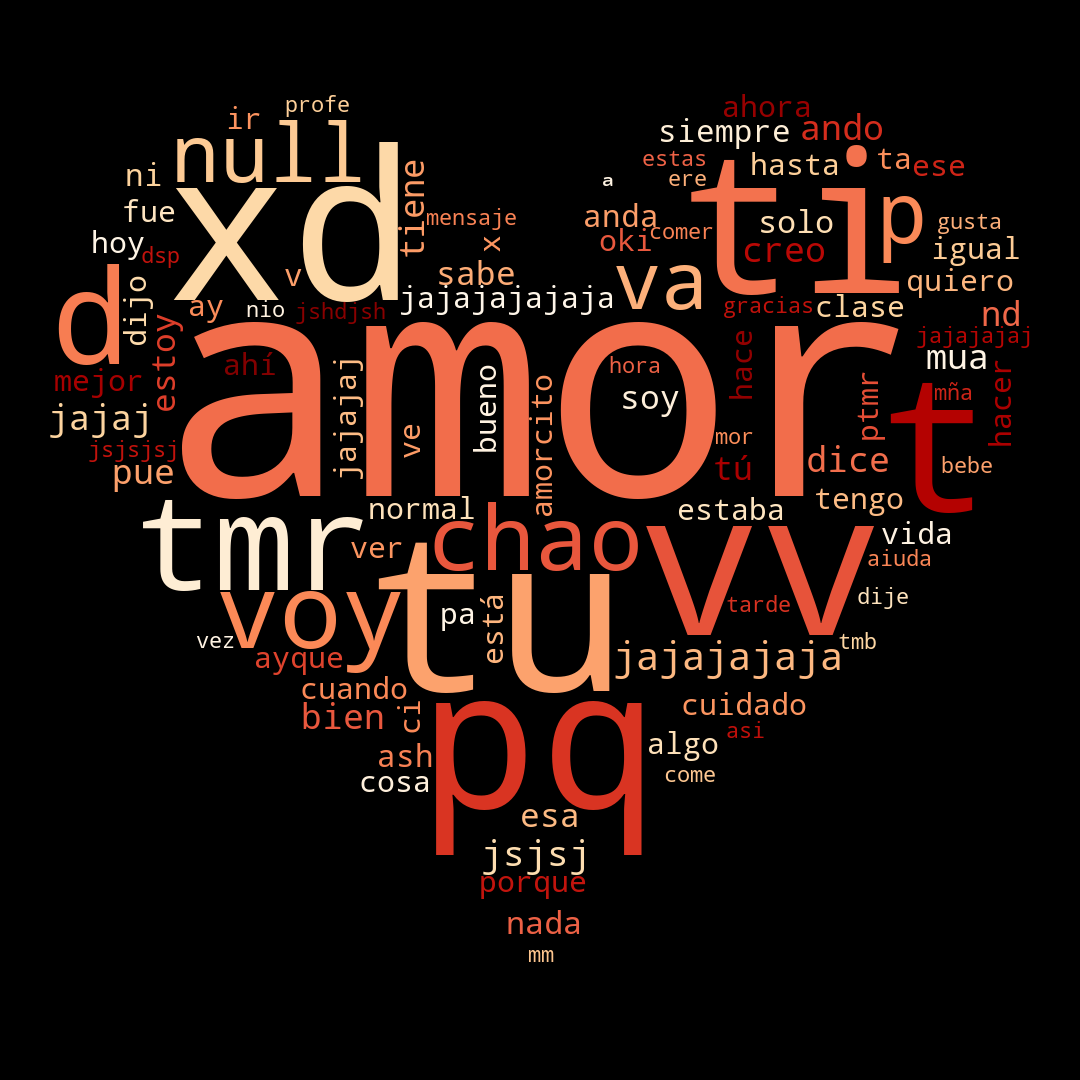

In [ ]:
# Crear un string que contendrá todas las palabras
total_palabras = ' '
stopwords = STOPWORDS.update(['que', 'qué', 'con', 'de', 'te', 'en', 'la', 'lo', 'le', 'el', 'las', 'los', 'les', 'por', 'es',
                              'son', 'se', 'para', 'un', 'una', 'chicos', 'su', 'si', 'chic','nos', 'ya', 'hay', 'esta',
                              'pero', 'del', 'mas', 'más', 'eso', 'este', 'como', 'así', 'todo', 'https','Multimedia','omitido',
                              'y', 'mi', 'o', 'q', 'yo', 'al'])

mask = np.array(Image.open('Resources/heart.jpg'))

# Obtener y acumular todas las palabras de cada mensaje
for mensaje in mensajes_df['Mensaje'].values:
    palabras = str(mensaje).lower().split() # Obtener las palabras de cada línea del txt
    for palabra in palabras:
        total_palabras = total_palabras + palabra + ' ' # Acumular todas las palabras

wordcloud = WordCloud(width = 800, height = 800, background_color ='black', stopwords = stopwords,
                      max_words=100, min_font_size = 5,
                      mask = mask, colormap='OrRd',).generate(total_palabras)

# Plotear la nube de palabras más usadas
wordcloud.to_image()